In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# 停词处理
def segment_text(text, stopwords):
    for j in range(text.shape[0]):
        for word in stopwords:
            if word in text[j]:
                text[j] = text[j].replace(word, '')
    # print(f"info of text: {type(text)}, {text.shape}, 
    #       info of stopwords: {type(stopwords)}, {len(stopwords)}")
    return text

# 加载停用词列表
def load_stopwords(stopwords_file):
    with open(stopwords_file, 'r', encoding='utf-8') as f:
        stopwords = [line.strip() for line in f]
    return set(stopwords)

# 加载数据集
label_mapping = defaultdict(int) # label mapping dictionary

def load_data(data_dir, stopwords_file):
    X = []
    X_total = []
    y = []

    # Mapping to convert labels to integers
    stopwords = load_stopwords(stopwords_file)
    categories = os.listdir(data_dir)
    global label_mapping

    for i, category in enumerate(categories):
        # 获取文件名作为label, label不在字典 label_mapping 中时，将其添加字典中
        label = os.path.splitext(category)[0]     
        if label not in label_mapping:
            label_mapping[label] = len(label_mapping)
        
        file_path = os.path.join(data_dir, category)
        with open(file_path, 'r', encoding='utf-8') as file:
            # 读取文件中的每一行，并将其存储为 NumPy 数组
            text = np.array(file.read().splitlines())
        # 移除停用词
        text = segment_text(text, stopwords)

        _b1 = text != '<text>' 
        _b2 = text != '</text>'
        # text 数组的对应元素同时满足 _b1 和 _b2 的条件
        _b = np.all(np.c_[_b1, _b2], axis=1)
        # print(f"info of skiping </text>: {type(_b)}, {_b.shape}")
        text = text[_b]
        # print(text) # 经过处理后的文本 numpy数组

        for sentence in text:
            # 一个句子 sentence 按照空格进行分割，
            words = sentence.split()
            X_total += words
            X.append(words)
            # y.append(label_mapping[label])
        y += [label_mapping[label]] * len(text)
        # print(len(X), len(y), len(X_total))
    return X, y



In [2]:

path_to_train_data = '../Tsinghua/train/'
path_to_test_data = '../Tsinghua/test/'
stopwords_file = '../Tsinghua/stop_words_zh.txt'

X_train, y_train = load_data(path_to_train_data, stopwords_file)
X_test, y_test = load_data(path_to_test_data, stopwords_file)

print(type(X_train), len(X_train))
print(type(y_train), len(y_train))
print(len(X_test))
print(len(y_test))

<class 'list'> 1195
<class 'list'> 1195
754
754


In [3]:
print(label_mapping)

defaultdict(<class 'int'>, {'体育': 0, '政治': 1, '教育': 2, '法律': 3, '电脑': 4, '经济': 5})


In [9]:
def create_word_vector(X, label_mapping, method):
    assert method in ['bernulli', 'multinomial'], 'Method must be either "bernulli" or "multinomial"'
    
    # Shape of word_matrix: (number of sentences, number of labels)
    word_matrix = np.zeros((len(X), len(label_mapping)))
    for i, sentence in enumerate(X):
        for word in sentence:
            if word in label_mapping.keys():
                if method == 'bernulli':
                    word_matrix[i, label_mapping[word]] = 1 
                elif method == 'multinomial':
                    word_matrix[i, label_mapping[word]] += 1
    return word_matrix

word_matrix_tb = create_word_vector(X_train, label_mapping, 'bernulli')
word_matrix_tm = create_word_vector(X_train, label_mapping, 'multinomial')
word_matrix_pb = create_word_vector(X_test, label_mapping, 'bernulli')
word_matrix_pm = create_word_vector(X_test, label_mapping, 'multinomial')

In [10]:
print(word_matrix_tb.shape, word_matrix_tm.shape)
print(np.sum(word_matrix_tb, axis=0))

(1195, 6) (1195, 6)
[ 89. 123. 250. 183.  91.   0.]


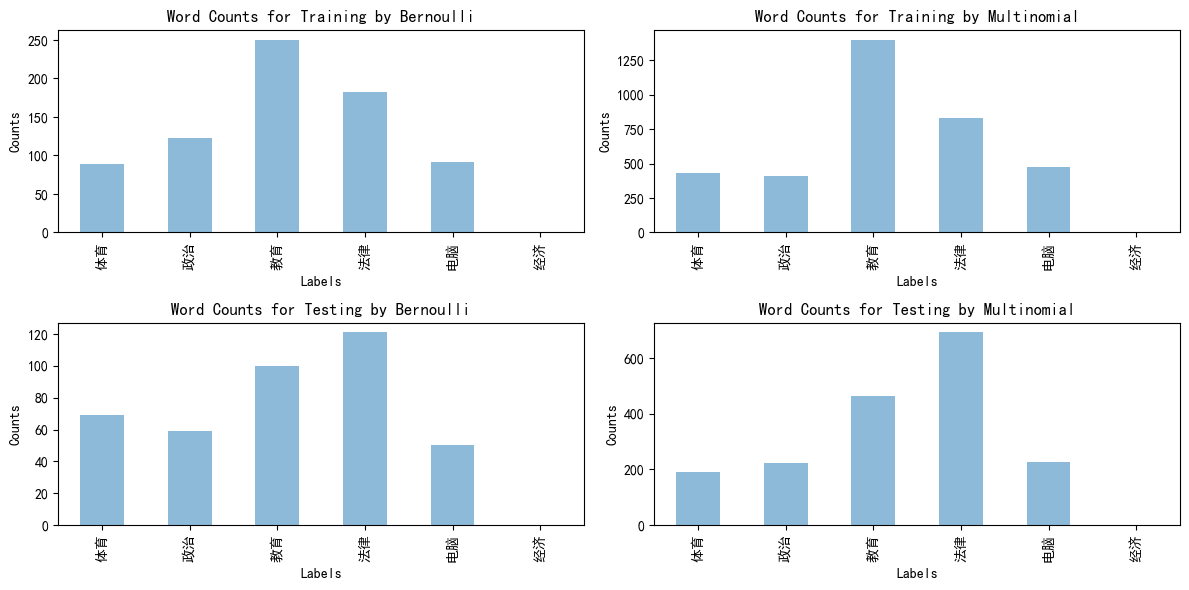

In [27]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

def visualize_data(word_matrix, label_mapping, title, fig):

    plt.rcParams['font.family'] = 'SimHei' # 解决不能输出中文的问题。不区分大小写，中括号可以不要
    plt.rcParams['figure.autolayout'] = True # 解决不能完整显示的问题（比如因为饼图太大，显示窗口太小）
    
    labels = list(label_mapping.keys())
    counts = np.sum(word_matrix, axis=0)
    data = pd.Series(counts, index=labels)

    data.plot.bar(ax=fig, alpha=0.5)
    fig.set_xlabel('Labels')
    fig.set_ylabel('Counts')
    fig.set_title(f'Word Counts for {title}')

fig, ax = plt.subplots(2, 2, figsize=(12, 6))
visualize_data(word_matrix_tb, label_mapping, 'Training by Bernoulli', fig=ax[0][0])
visualize_data(word_matrix_tm, label_mapping, 'Training by Multinomial', fig=ax[0][1])
visualize_data(word_matrix_pb, label_mapping, 'Testing by Bernoulli', fig=ax[1][0])
visualize_data(word_matrix_pm, label_mapping, 'Testing by Multinomial', fig=ax[1][1])

In [14]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

classifier = MultinomialNB()
classifier.fit(word_matrix_tm, y_train)
 
# predicting test set results
y_pred = classifier.predict(word_matrix_pm)
 
# making the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[278   0   1   0   3   0]
 [ 38  30   9   3   1   1]
 [ 22   1  35   1   1   3]
 [ 43   7   9  81   0  12]
 [ 16   0   1   2  35   1]
 [ 99   1   2  11   5   2]]


0.6114058355437666

In [15]:
from sklearn.svm import SVC

svm_multi = SVC()
svm_bernu = SVC()
svm_multi.fit(word_matrix_tm, y_train)
svm_bernu.fit(word_matrix_tb, y_train)

SVC()

In [16]:
svm_multi.score(word_matrix_pm, y_test)

0.5954907161803713

In [17]:
svm_bernu.score(word_matrix_pb, y_test)

0.6180371352785146

In [22]:
class MultinomialNBC(object):
    def __init__(self):
        self.class_prior_ = None # (n_classes,)
        self.ftr_log_prob_ = None 
        self.classes = None # (n_classes,)
        self.ftr_counts = None # (n_classes, n_features)
        self.n_classes = None 

    def fit(self, X_counts, y):
        self.classes = np.unique(y) # get unique classes
        self.n_classes = len(self.classes) # num of classes
        self.class_counts = np.zeros(self.n_classes)
        self.ftr_counts = np.zeros((self.n_classes, X_counts.shape[1]))

        for i, cls_ in enumerate(self.classes):
            cls_indices = np.where(y == cls_)[0] # get indices of class cls_
            self.class_counts[i] = len(cls_indices)
            self.ftr_counts[i] = np.array(X_counts[cls_indices].sum(axis=0)).flatten()

        # calculate class priors and feature log probabiltes 
        self.class_prior_ = self.class_counts / np.sum(self.class_counts)
        self.ftr_log_prob_ =  np.log(self.ftr_counts + 1) - \
            np.log((np.sum(self.ftr_counts, axis=1, keepdims=True) + self.n_classes))

    def predict(self, X_counts):
        # print(X_counts.shape, self.ftr_log_prob_.shape)
        # calculate log likelihoods for each class
        log_likelihoods = np.dot(X_counts, self.ftr_log_prob_.T) + np.log(self.class_prior_)
        # predict the class with the highest log likelihood
        return self.classes[np.argmax(log_likelihoods, axis=1)]
    
classifier = MultinomialNBC()
classifier.fit(word_matrix_tm, y_train)
results = classifier.predict(word_matrix_pm)
acc = np.mean(results == y_test)
print(f"accuracy for Multinomial NB Classifier: {acc}")

(754, 6) (6, 6)
accuracy for Multinomial NB Classifier: 0.6114058355437666


In [24]:
class BernulliNBC(object):
    def __init__(self):
        self.class_prior_ = None # (n_classes,)
        self.ftr_log_prob_ = None 
        self.classes = None # (n_classes,)
        self.ftr_counts = None # (n_classes, n_features)
        self.n_classes = None 

    def fit(self, X_bin, y):
        self.classes = np.unique(y) # get unique classes
        self.n_classes = len(self.classes) # num of classes
        self.class_counts = np.zeros(self.n_classes)
        self.ftr_counts = np.zeros((self.n_classes, X_bin.shape[1]))

        for i, cls_ in enumerate(self.classes):
            cls_indices = np.where(y == cls_)[0] # get indices of class cls_
            self.class_counts[i] = len(cls_indices)
            self.ftr_counts[i] = np.array(X_bin[cls_indices].sum(axis=0)).flatten()
        # calculate class priors and feature log probabiltes
        self.class_prior_ = self.class_counts / np.sum(self.class_counts)
        self.ftr_log_prob_ =  np.log(self.ftr_counts + 1) - \
            np.log((np.sum(self.ftr_counts, axis=1, keepdims=True) + 2))

    def predict(self, X_bin):
        log_likelihoods = np.dot(X_bin, self.ftr_log_prob_.T) + np.log(self.class_prior_)
        return self.classes[np.argmax(log_likelihoods, axis=1)]
    
classifier = BernulliNBC()
classifier.fit(word_matrix_tb, y_train)
results = classifier.predict(word_matrix_pb)
acc = np.mean(results == y_test)
print(f"accuracy for Bernonulli NB Classifier: {acc}")

accuracy for Bernonulli NB Classifier: 0.5994694960212201
